In [137]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing

In [138]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [139]:
n_features = 100
X, y = make_classification(n_clusters_per_class = 6, n_samples = 4000, n_features = n_features, n_informative = 20, random_state=8, flip_y= 0.01)
X_train, X_test = np.split(X, [1000])
y_train, y_test = np.split(y, [1000])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [140]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear'):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

In [105]:
#RANDOM_SELECTION()
#RANDOM_SELECTION(kernel='linear')

#data.kernel_matrix = 'poly'
#RANDOM_SELECTION(kernel='precomputed')

#data.kernel_matrix = None
#RANDOM_SELECTION(kernel='poly')

# SVM

In [141]:
@time_func
def SVM_RFE_W_STEP(step, C = 0.5, degree = 3, kernel = 'linear', w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.degree = degree
    kf = KFold(n_splits=6, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

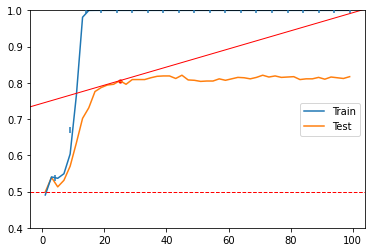

AT (25, 0.8060265012144386, 0.2051787990284491) WITH 20 ITERATIONS IN 14.152061462402344 SECONDS : 0.04112860890897233
__main__.SVM_RFE_W_STEP - 00:00:19.774154700


In [146]:
SVM_RFE_W_STEP(5, 0.3, 3, 'poly')


In [108]:
def check_pairwise_arrays(X, Y):
    if X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
            "X.shape[1] == %d while Y.shape[1] == %d" % (X.shape[1], Y.shape[1]))
    return X, Y

def combolution(X, Y, k, K=None, feat=None):
    if K is None:
        K = np.empty((m, n), dtype=float)

    if feat is None:
        m = X.shape[0]
        n = Y.shape[0]
        for i in range(m):
            for j in range(n):
                K[i, j] = k(X[i],Y[j])
    else:
        for i in feat:
            for j in feat:
                K[i, j] = k(X[i],Y[j])
    return K

def euclidean_distances(X, Y):
    #X, Y = check_pairwise_arrays(X, Y)
    distances = - 2 * np.dot(X, Y.T)
    return distances


def polynomial_kernel(X, Y, degree=3, gamma=None, coef0=1, feat=None, K=None):
    X, Y = check_pairwise_arrays(X, Y)

    if gamma is None:
        gamma = 1.0 / X.shape[1]

    def k(a, b):
        return  (np.dot(a, b) * gamma + coef0) ** degree
    
    return combolution(X, Y, k, K, feat)

def rbf_kernel(X, Y, gamma=None, feat=True):
    X, Y = check_pairwise_arrays(X, Y)

    if gamma is None:
        gamma = 1.0 / X.shape[1]

    #def k(a, b):
    #    c = a - b
    #    return np.exp(-gamma * np.dot(c, c))

    K = pairwise.euclidean_distances(X, Y, squared=True)
    K *= -gamma
    np.exp(K, K)
    return K


class Problem():
    def __init__(self, C=1, kernel='linear', gamma = 1.0, degree = 3):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree

        self.nY = None
        self._H_y = None

    def computeKernelMatrix(self, X, Y):
        if self.kernel == 'linear': return pairwise.polynomial_kernel(X, Y, degree=1)
        if self.kernel == 'poly': return pairwise.polynomial_kernel(X, Y, coef0=self.C, degree=self.degree)
        if self.kernel == 'rbf': return pairwise.rbf_kernel(X, Y, gamma=self.gamma)

    def computeKernelMatrix2(self, X, K = None, feat = True):
        if self.kernel == 'linear': return polynomial_kernel(X, X, degree=1, K = K, feat = feat)
        if self.kernel == 'poly': return polynomial_kernel(X, X, coef0=self.C, degree=self.degree, K = K, feat = feat)
        if self.kernel == 'rbf': return rbf_kernel(X, X, gamma=self.gamma)

    def computeHessianMatrix(self, K):
        return np.multiply(self._H_y, K)

    def getKernelFunction(self):
        if self.kernel == 'linear':
            def k(a, b):
                return np.dot(a, b)
            return k
        if self.kernel == 'poly':
            pass
        if self.kernel == 'rbf':
            g = -self.gamma
            def k(a, b):
                c = a - b
                return np.exp(g * np.dot(c, c))
            return k

    def time(self, name, f):
        start_time = time.time()
        K = f()
        elapsed_time = time.time() - start_time
        print(self.kernel, name, ' IN ', elapsed_time, 's')

    def pkern(self, X, feat=True):
        print('SKLEARN\n', self.computeKernelMatrix(X, X))
        print('MINE_KERN\n', self.computeKernelMatrix2(X, X))

        K = self.computeKernelMatrix(X, X)
        features = random.sample(range(0, self.n_features), self.n_features)
        X = X[:,]
        print('MINE\n', self.computeKernelMatrix2(X, K, feat))

    def ptime(self, X):
        self.time('SKLEARN', lambda: self.computeKernelMatrix(X, X))
        self.time('MINE', lambda: self.computeKernelMatrix2(X, X))

In [109]:
X, y = make_classification(n_samples = 4, n_features=2, n_redundant=0)
prob = Problem(kernel='poly')
prob.pkern(X, feat=[1])

prob = Problem(kernel='rbf')
prob.pkern(X)

SKLEARN
 [[ 4.15630987e+02  4.60375674e+01  1.43457966e+01 -1.72629458e-01]
 [ 4.60375674e+01  2.72106840e+01  5.94063633e-01 -7.27055006e-02]
 [ 1.43457966e+01  5.94063633e-01  6.48352705e+00  1.96170213e+00]
 [-1.72629458e-01 -7.27055006e-02  1.96170213e+00  8.28361980e+00]]


TypeError: 'bool' object is not iterable

In [46]:
X, y = make_classification(n_samples = 1000, n_features=200)
prob = Problem(kernel='poly')
prob.ptime(X)

prob = Problem(kernel='rbf')
prob.ptime(X)

poly SKLEARN  IN  0.03200054168701172 s
poly MINE  IN  2.1606361865997314 s
rbf SKLEARN  IN  0.01599717140197754 s
rbf MINE  IN  3.6482324600219727 s
